In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import MeanSquaredError
import yfinance as yf

# Ensure that the seaborn style is used for the plots
sns.set()

In [2]:
#DATA COLLECTION OF OUR STOCK  

In [3]:
# Defining the stock ticker and the time period of data fetched
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetching the stock data using yfinance API
stock_data = yf.download(ticker, start=start_date, end=end_date)

stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876099,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167618,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742653,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400551,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565193,132079200


In [4]:
#DATA PRE PROCESSING FOR INITIAL ANALYSIS, DATA CLENSING 
#DATA VISUALIZATION TO OBSERVE THE CLOSING PRICE AND VOLUME OF SALES

/var/folders/nf/1cfn8zmn3974xm77ml6fp8k80000gn/T/ipykernel_20793/3267373883.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


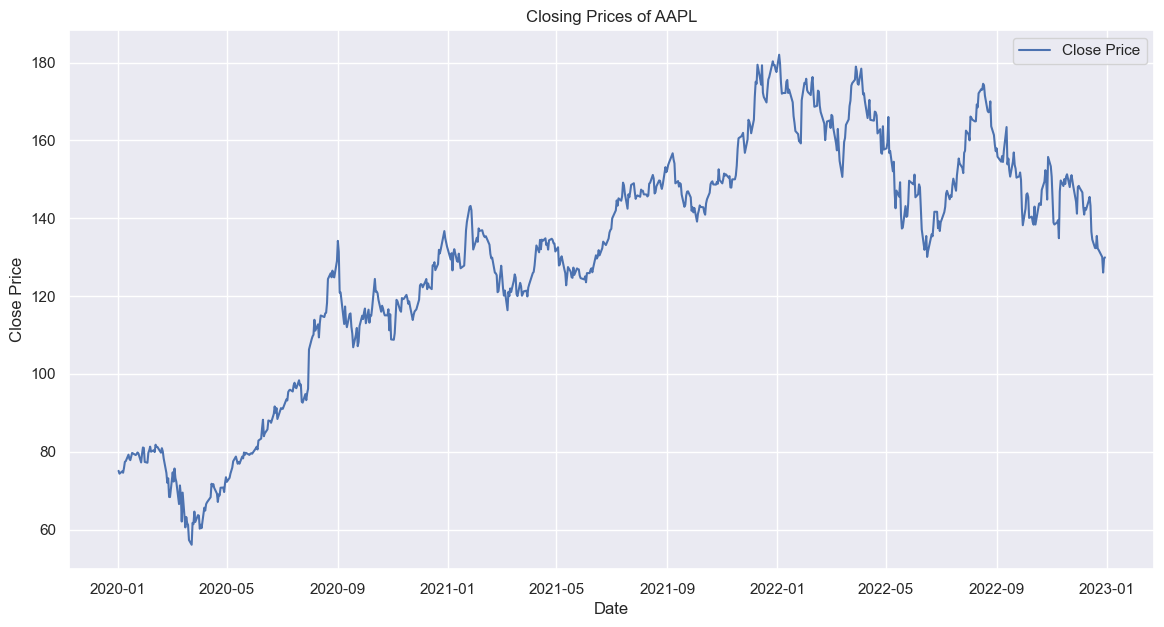

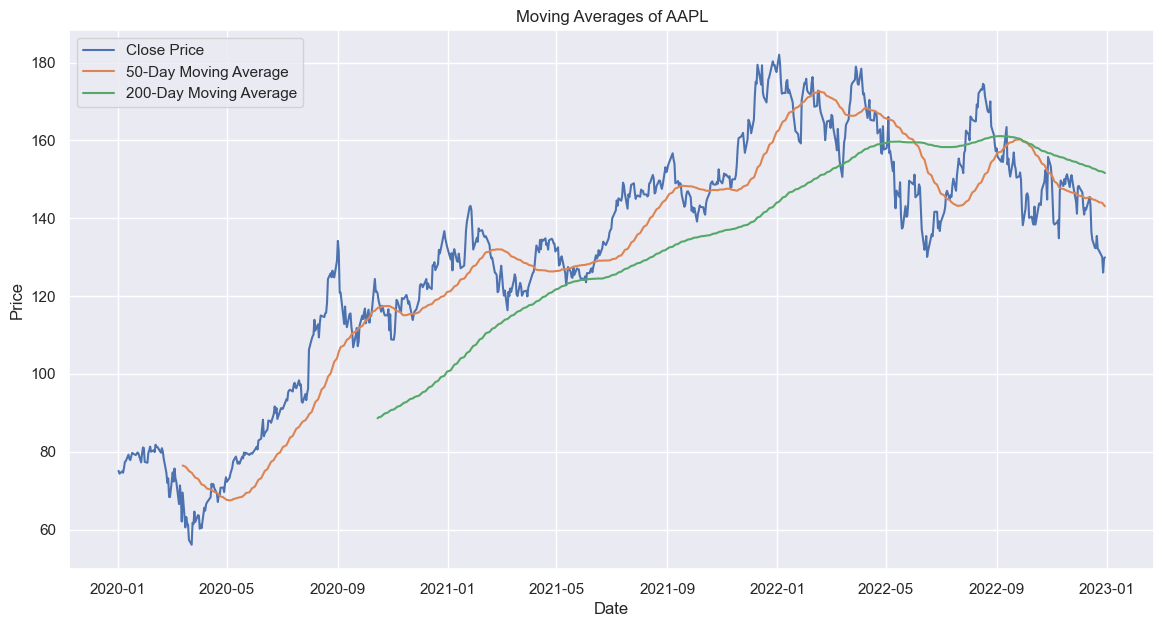

In [5]:
# Descriptive statistics
stock_data.describe()

# Data Cleaning AND Checking for null values
print(stock_data.isnull().sum())

# Filling any missing values with the forward fill method
stock_data.fillna(method='ffill', inplace=True)

# Data Visualization: Closing Prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price')
plt.title('Closing Prices of AAPL')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculating the Moving Average
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA200'] = stock_data['Close'].rolling(window=200).mean()

# Visualizing Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price')
plt.plot(stock_data['MA50'], label='50-Day Moving Average')
plt.plot(stock_data['MA200'], label='200-Day Moving Average')
plt.title('Moving Averages of AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
#STATISTICAL ANYLZING OF THE DATA BASED ON DAILY RETURNS AND HEATMAPPING USING CORRELATION MATRIX

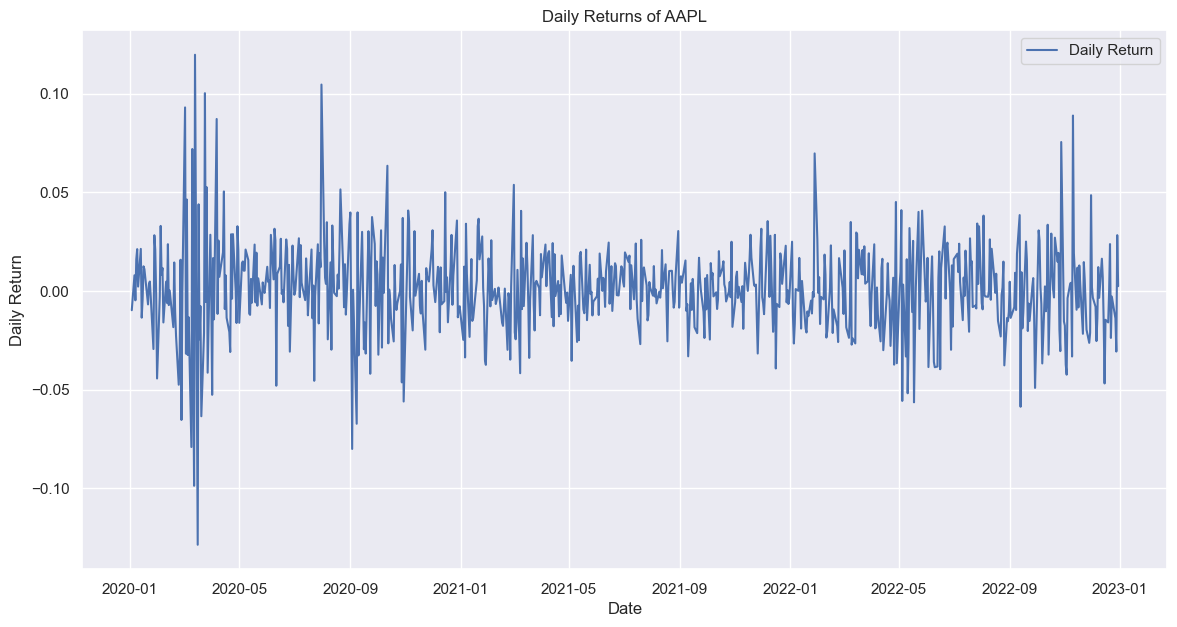

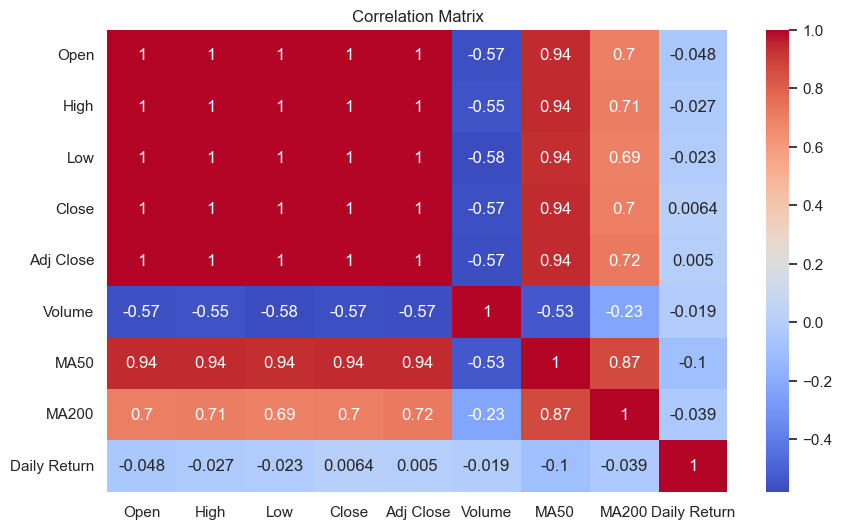

In [7]:
# Daily Returns of the stock
stock_data['Daily Return'] = stock_data['Close'].pct_change()

# Plotting Daily Returns using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Daily Return'], label='Daily Return')
plt.title('Daily Returns of AAPL')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

# Correlation Plot (with itself here, but can be extended to other stocks)
plt.figure(figsize=(10, 6))
sns.heatmap(stock_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [8]:
#BUILDING THE MODEL

In [9]:
# Data Scaling THROUGH Min-Max scaling to normalize the input features.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

# Prepare the data for RNN-LSTM
def prepare_data(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = prepare_data(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Spliting the data into training and testing sets
training_size = int(len(X) * 0.8)
test_size = len(X) - training_size
X_train, X_test = X[:training_size], X[training_size:]
Y_train, Y_test = Y[:training_size], Y[training_size:]

#RNN model using Keras with an LSTM layer for handling temporal dependencies.
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))#Dense Sequential Model to predict future stock prices based on historical data.
model.add(Dense(1))

# Compiling the model

model.compile(optimizer='adam', loss='mean_squared_error')

# Training of the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0233


In [13]:
history = model.fit(X_train, Y_train, batch_size=1, epochs=10, validation_split=0.2)

Epoch 1/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 2/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 3/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 4/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 8.5736e-04 - val_loss: 0.0010
Epoch 7/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 7.9740e-04 - val_loss: 0.0015
Epoch 8/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0011 - val_loss: 9.5047e-04
Epoch 9/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 7.6362e-04 - val_loss: 8.7591e-04
Epoch 10/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 7.4576e-04 - val_loss: 0.0022


In [15]:
# Dense Sequential Model to predict future stock prices based on historical data.
print(history.history)

{'loss': [0.0020595297683030367, 0.001562311314046383, 0.0015425330493599176, 0.0015306150307878852, 0.0010837418958544731, 0.0010388476075604558, 0.0008708750829100609, 0.0009547664085403085, 0.0008967288304120302, 0.0007927785627543926], 'val_loss': [0.002987090963870287, 0.006097410339862108, 0.0033417707309126854, 0.0017126271268352866, 0.001195745775476098, 0.0010418064193800092, 0.0014647893840447068, 0.0009504712070338428, 0.0008759064367040992, 0.0021717529743909836]}


In [17]:
print(X_train.shape)
print(Y_train.shape)

(524, 100, 1)
(524,)


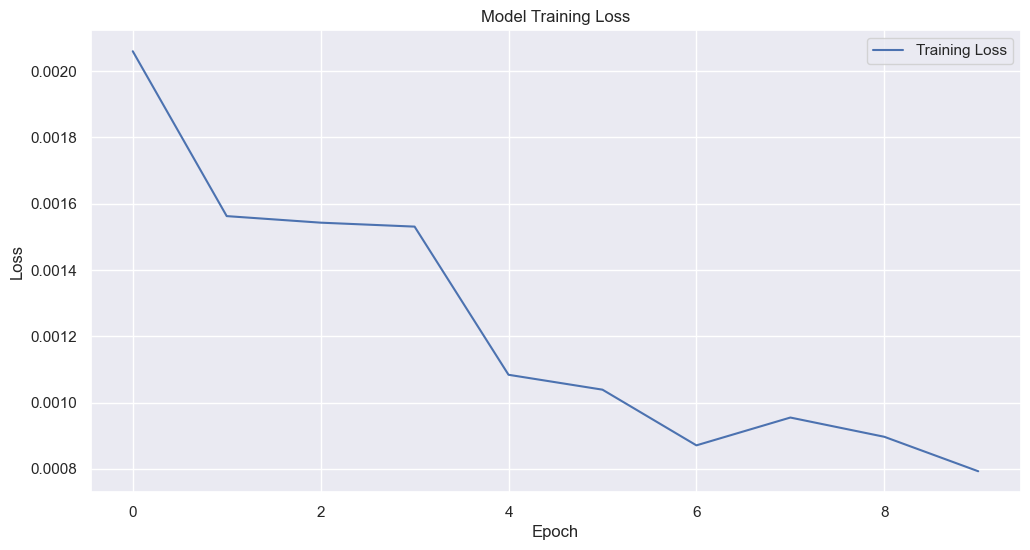

In [19]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 8.1354e-04 - val_loss: 9.7953e-04
Epoch 2/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 6.8914e-04 - val_loss: 0.0011
Epoch 3/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 7.1667e-04 - val_loss: 0.0010
Epoch 4/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 6.5652e-04 - val_loss: 0.0021
Epoch 5/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 5.9197e-04 - val_loss: 0.0031
Epoch 6/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 7.6473e-04 - val_loss: 8.4369e-04
Epoch 7/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 6.7111e-04 - val_loss: 0.0019
Epoch 8/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5.9939e-04 - val_loss: 8.6018e-04
Epoch 9/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 7.0523e-04 - val_loss: 0.0028
Epoch 10/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 7.5675e-04 - val_loss: 8.4646e-04
dict_keys(['loss', 'val_loss'])
[0.0006655498873442411, 0.000715221569407

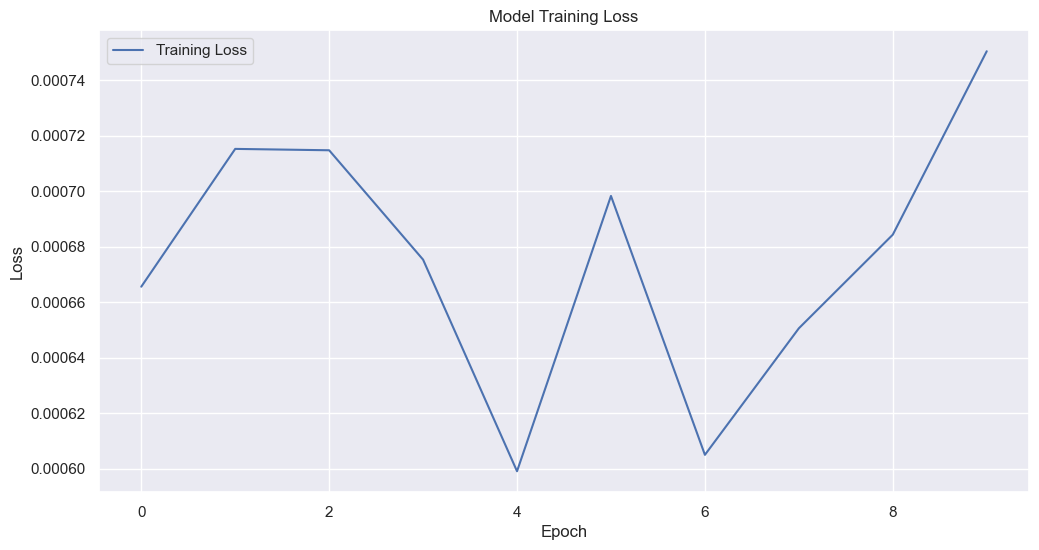

In [21]:
# Fit the model
history = model.fit(X_train, Y_train, batch_size=1, epochs=10, validation_split=0.2)

# Check history contents
print(history.history.keys())  # Should include 'loss'
print(history.history['loss'])  # Should contain loss values

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#evaluation of the model

In [27]:
# # Predicting the stock prices
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

# # Transforming it back to original form using inverse transform to get the data in graph close price vs date
# train_predict = scaler.inverse_transform(train_predict)
# test_predict = scaler.inverse_transform(test_predict)

# # Calculating Mean Squared Error
# mse_train = MeanSquaredError()(Y_train, train_predict).numpy()
# mse_test = MeanSquaredError()(Y_test, test_predict).numpy()

# print(f'Train Mean Squared Error: {mse_train}')
# print(f'Test Mean Squared Error: {mse_test}')

# # Plotting the results
# plt.figure(figsize=(14, 7))
# plt.plot(stock_data['Close'], label='Actual Close Price')
# plt.plot(range(time_step, len(train_predict) + time_step), train_predict, label='Train Predict')
# plt.plot(range(len(train_predict) + 2 * time_step, len(train_predict) + 2 * time_step + len(test_predict)), test_predict, label='Test Predict')
# plt.title('Stock Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Train Mean Squared Error: 7.4498913365478225
Test Mean Squared Error: 10.88587179219169


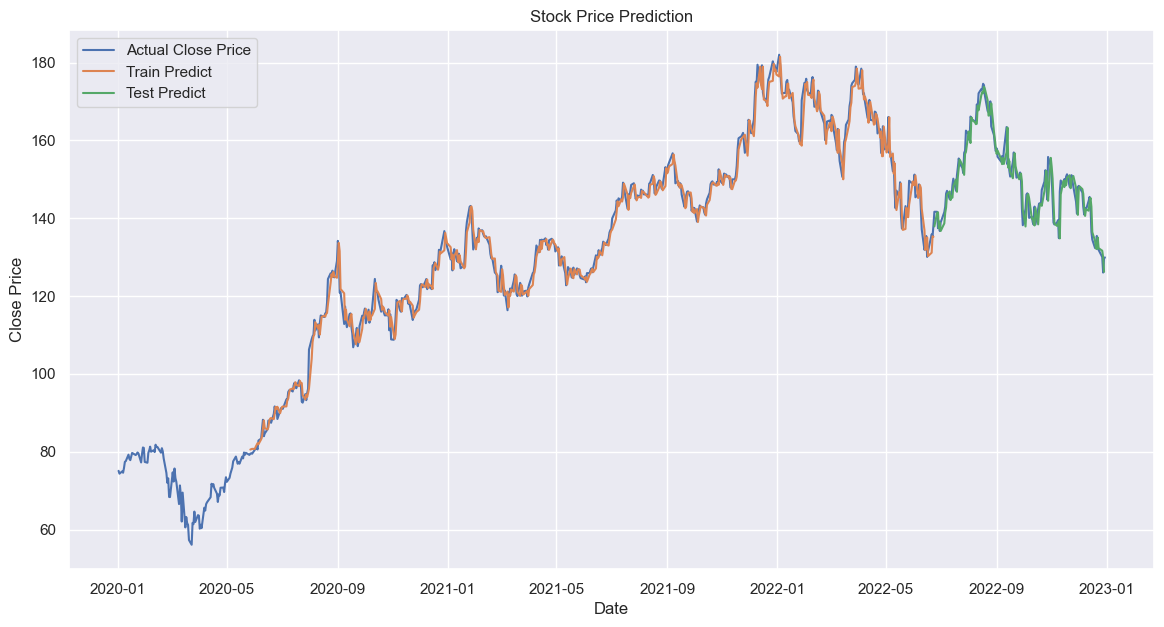

In [48]:
# Predicting the stock prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transforming the actual training and test values to match the scale
Y_train_scaled = scaler.inverse_transform([Y_train])
Y_test_scaled = scaler.inverse_transform([Y_test])

# Calculating Mean Squared Error
mse_train = mean_squared_error(Y_train_scaled[0], train_predict)
mse_test = mean_squared_error(Y_test_scaled[0], test_predict)

print(f'Train Mean Squared Error: {mse_train}')
print(f'Test Mean Squared Error: {mse_test}')

# Preparing the plot data
train_plot = np.empty_like(stock_data['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict) + time_step] = train_predict.flatten()

test_plot = np.empty_like(stock_data['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict) + (time_step):len(train_predict) + (time_step) + len(test_predict)] = test_predict.flatten()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'], label='Actual Close Price')
plt.plot(stock_data.index, train_plot, label='Train Predict')
plt.plot(stock_data.index, test_plot, label='Test Predict')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()